In [1]:
import tensorboard

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import src.data.Dataset as dt

In [3]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [4]:
IMAGES_TRAIN_DATASET_PATH = os.path.abspath(
    "./data/processed/preprocessed_megadetector"
)

TRAIN_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Train.csv"
)
VALIDATION_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv"
)
TEST_SAMPLES_CSV = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL/28570Test.csv")

print(f"TRAIN_SAMPLES_CSV:      {TRAIN_SAMPLES_CSV}")
print(f"VALIDATION_SAMPLES_CSV: {VALIDATION_SAMPLES_CSV}")
print(f"TEST_SAMPLES_CSV:       {TEST_SAMPLES_CSV}")

TRAIN_SAMPLES_CSV:      /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv
VALIDATION_SAMPLES_CSV: /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv
TEST_SAMPLES_CSV:       /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv


In [5]:
train_dataframe = dt.load_from_csv(TRAIN_SAMPLES_CSV)
validation_dataframe = dt.load_from_csv(VALIDATION_SAMPLES_CSV)
test_dataframe = dt.load_from_csv(TEST_SAMPLES_CSV)

The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv has been successfully opened.


In [6]:
train_dataframe["file_name"] = train_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_TRAIN_DATASET_PATH, x)
)
train_dataframe["binary_label"] = train_dataframe["binary_label"].astype(str)

validation_dataframe["file_name"] = validation_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_TRAIN_DATASET_PATH, x)
)
validation_dataframe["binary_label"] = validation_dataframe["binary_label"].astype(str)

test_dataframe["file_name"] = test_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_TRAIN_DATASET_PATH, x)
)
test_dataframe["binary_label"] = test_dataframe["binary_label"].astype(str)

In [7]:
train_dataframe = train_dataframe.drop_duplicates()
validation_dataframe = validation_dataframe.drop_duplicates()
test_dataframe = test_dataframe.drop_duplicates()

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 254
EPOCHS = 25
MODEL_NAME = "MegaClassifier"
VERSION = 1.3

train_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)
normal_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

validation_images = normal_datagen.flow_from_dataframe(
    dataframe=validation_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

test_images = normal_datagen.flow_from_dataframe(
    dataframe=test_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 19991 validated image filenames belonging to 2 classes.
Found 4284 validated image filenames belonging to 2 classes.
Found 4288 validated image filenames belonging to 2 classes.


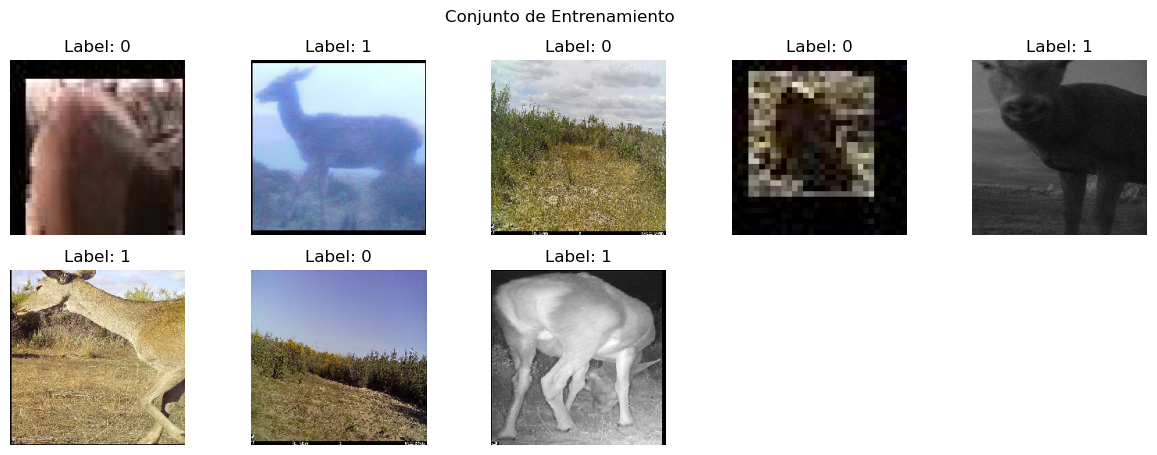

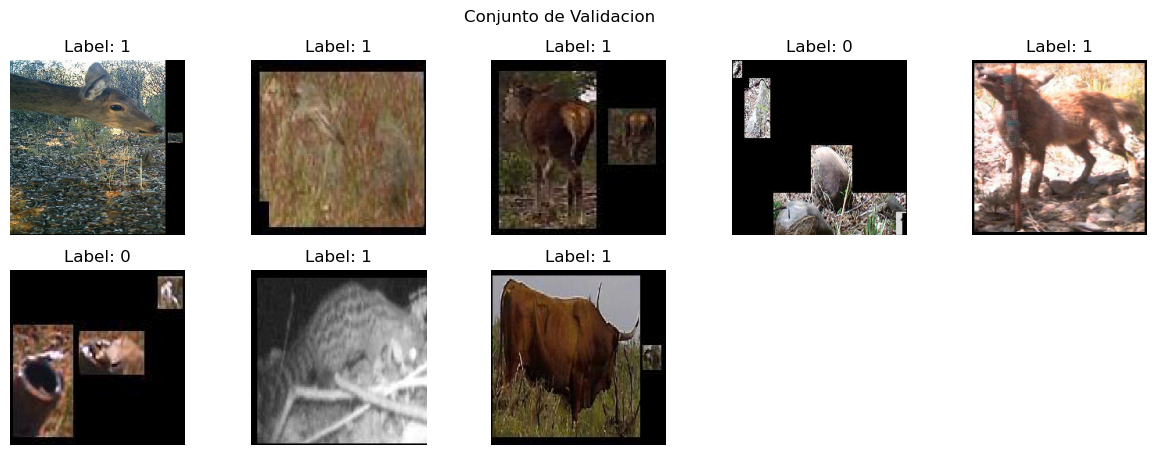

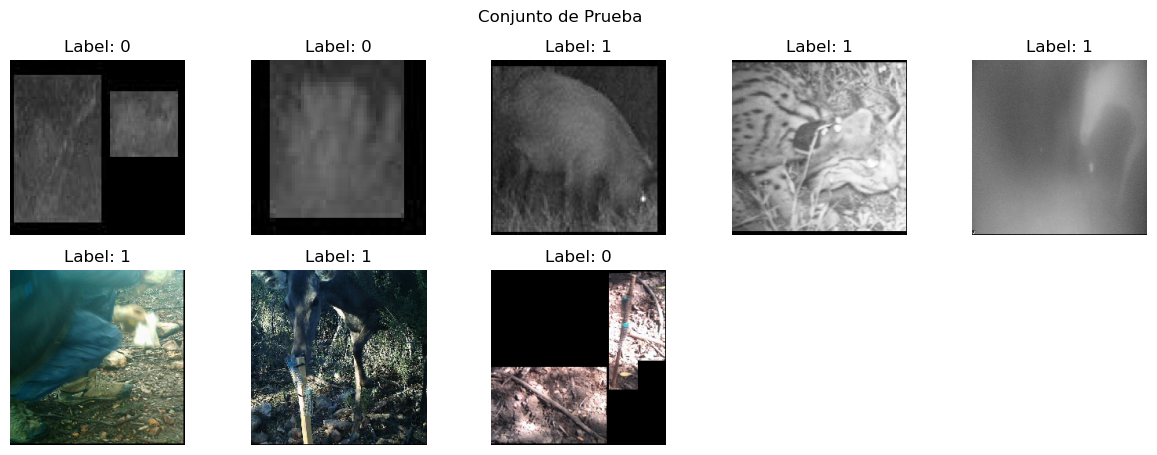

In [9]:
def show_random_images_from_generator(generator, title):
    images, labels = next(generator)
    # Asegúrate de que las imágenes estén en el rango [0, 1] para visualizarlas correctamente
    images = (
        images + 1
    ) * 127.5  # Si las imágenes están en el rango [-1, 1], esto las lleva a [0, 255]
    images = np.clip(images, 0, 255)  # Asegúrate de que no haya valores fuera de rango

    plt.figure(figsize=(15, 5))
    for i in range(8):
        plt.subplot(2, 5, i + 1)
        plt.imshow(
            images[i].astype("uint8")
        )  # Convierte a enteros de 8 bits para la visualización
        plt.title(f"Label: {int(labels[i])}")

        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_random_images_from_generator(train_images, "Conjunto de Entrenamiento")
show_random_images_from_generator(validation_images, "Conjunto de Validacion")
show_random_images_from_generator(test_images, "Conjunto de Prueba")

In [10]:
base_model = tensorflow.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

# Construir el modelo básico
model = tensorflow.keras.models.Sequential(
    [
        base_model,
        tensorflow.keras.layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name=f"{MODEL_NAME}_v.{VERSION}",
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        "binary_accuracy",
        Precision(name="presision"),
        Recall(name="recall"),
        AUC(name="auc"),
        TruePositives(name="tp"),
        FalsePositives(name="fp"),
        TrueNegatives(name="tn"),
        FalseNegatives(name="fn"),
    ],
)

model.summary()

2024-12-29 19:56:55.158787: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-29 19:56:55.158814: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-29 19:56:55.158821: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-29 19:56:55.158845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-29 19:56:55.158857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "MegaClassifier_v.1.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [11]:
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=EPOCHS,
    callbacks=[TensorBoard(log_dir=f"./logs/{MODEL_NAME}/v.{VERSION}")],
)

Epoch 1/25


2024-12-29 19:56:57.559792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8246 - binary_accuracy: 0.8246 - presision: 0.8373 - recall: 0.9120 - auc: 0.8992 - tp: 12062.0000 - fp: 2343.0000 - tn: 4422.0000 - fn: 1164.0000

2024-12-29 19:58:01.390434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 79s 979ms/step - loss: 0.3821 - accuracy: 0.8246 - binary_accuracy: 0.8246 - presision: 0.8373 - recall: 0.9120 - auc: 0.8992 - tp: 12062.0000 - fp: 2343.0000 - tn: 4422.0000 - fn: 1164.0000 - val_loss: 0.2557 - val_accuracy: 0.8996 - val_binary_accuracy: 0.8996 - val_presision: 0.8986 - val_recall: 0.9563 - val_auc: 0.9613 - val_tp: 2711.0000 - val_fp: 306.0000 - val_tn: 1143.0000 - val_fn: 124.0000
Epoch 2/25
79/79 [==============================] - 76s 963ms/step - loss: 0.2363 - accuracy: 0.9022 - binary_accuracy: 0.9022 - presision: 0.9137 - recall: 0.9410 - auc: 0.9651 - tp: 12446.0000 - fp: 1176.0000 - tn: 5589.0000 - fn: 780.0000 - val_loss: 0.2174 - val_accuracy: 0.9148 - val_binary_accuracy: 0.9148 - val_presision: 0.9288 - val_recall: 0.9436 - val_auc: 0.9700 - val_tp: 2675.0000 - val_fp: 205.0000 - val_tn: 1244.0000 - val_fn: 160.0000
Epoch 3/25
79/79 [==============================] - 76s 959ms/step - loss: 0.2102 - accuracy: 0.9114

In [12]:
model.save(f"./models/{MODEL_NAME}/{MODEL_NAME}_v.{VERSION}.h5")

/Users/carlos/miniconda3/envs/TFG/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
history_df = pd.DataFrame(history.history)
history_df.to_csv(
    f"./logs/{MODEL_NAME}/v.{VERSION}/train_validation_history.csv", index=False
)

In [14]:
results = model.evaluate(test_images)
# Nombres de las métricas
metric_names = model.metrics_names

# Crear un diccionario con las métricas y los valores
evaluation_results = {
    ("test_" + name): value for name, value in zip(metric_names, results)
}
evaluation_df = pd.DataFrame([evaluation_results])
evaluation_df.to_csv(f"./logs/{MODEL_NAME}/v.{VERSION}/test_history.csv", index=False)
evaluation_results


17/17 [==============================] - 14s 767ms/step - loss: 0.1508 - accuracy: 0.9452 - binary_accuracy: 0.9452 - presision: 0.9480 - recall: 0.9704 - auc: 0.9844 - tp: 2753.0000 - fp: 151.0000 - tn: 1300.0000 - fn: 84.0000


{'test_loss': 0.1508164256811142,
 'test_accuracy': 0.9451959133148193,
 'test_binary_accuracy': 0.9451959133148193,
 'test_presision': 0.9480027556419373,
 'test_recall': 0.9703912734985352,
 'test_auc': 0.9844487905502319,
 'test_tp': 2753.0,
 'test_fp': 151.0,
 'test_tn': 1300.0,
 'test_fn': 84.0}